# The boundary element method

In this notebook we are going to solve the

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
import meshio

In [3]:
try:
    repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
    style = repo + "/styles/clean.mplstyle"
    plt.style.use(style)
except:
    pass

The following function assemble the matrices from
the influence coefficients.

In [4]:
def assem(coords, elems):
    """Assembly matrices for the BEM problem

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.

    Returns
    -------
    Gmat : ndarray, float
        Influence matrix for the flow.
    Hmat : ndarray, float
        Influence matrix for primary variable.
    """
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = mean(coords[elem2], axis=0)
            if ev_cont == col_cont:
                L = norm(coords[elem1[1]] - coords[elem1[0]])
                Gmat[ev_cont, ev_cont] = - L/(2*pi)*(log(L/2) - 1)
                Hmat[ev_cont, ev_cont] = - 0.5
            else:
                Gij, Hij = influence_coeff(elem1, coords, pt_col)
                Gmat[ev_cont, col_cont] = Gij
                Hmat[ev_cont, col_cont] = Hij
    return Gmat, Hmat

The influence coefficients are computed analytically
as

In [5]:
def influence_coeff(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the elements.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    F_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    r_A = rotmat.dot(coords[elem[0]] - pt_col)
    r_B = rotmat.dot(coords[elem[1]] - pt_col)
    theta_A = arctan2(r_A[1], r_A[0])
    theta_B = arctan2(r_B[1], r_B[0])
    if norm(r_A) <= 1e-6:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0]
    elif norm(r_B) <= 1e-6:
        G_coeff = -(r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    else:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0] -\
                  (r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    H_coeff = theta_B - theta_A
    return -G_coeff/(2*pi), H_coeff/(2*pi)

The following function evaluate the solution
to the nodes in the 2D mesh.

In [6]:
def eval_sol(ev_coords, coords, elems, u_boundary, q_boundary):
    """Evaluate the solution in a set of points

    Parameters
    ----------
    ev_coords : ndarray, float
        Coordinates of the evaluation points.
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.
    u_boundary : ndarray, float
        Primary variable in the nodes.
    q_boundary : [type]
        Flows in the nodes.

    Returns
    -------
    solution : ndarray, float
        Solution evaluated in the given points.
    """
    npts = ev_coords.shape[0]
    solution = np.zeros(npts)
    for k in range(npts):
        for ev_cont, elem in enumerate(elems):        
            pt_col = ev_coords[k]
            G, H = influence_coeff(elem, coords, pt_col)
            solution[k] += u_boundary[ev_cont]*H - q_boundary[ev_cont]*G
    return solution

Now, let us run a simulation.

In [7]:
mesh = meshio.read("files/disk.msh")

In [8]:
elems = np.vstack([cells.data for cells in mesh.cells[0:4]])
bound_nodes = list(set(elems.flatten()))
coords = mesh.points[bound_nodes, :2]
x, y = coords.T
tris = mesh.cells[4].data

In [9]:
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
theta = np.arctan2(y_m, x_m)
u_boundary = 3*np.cos(6*theta)

In [10]:
Gmat, Hmat = assem(coords, elems)

In [11]:
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

In [12]:
ev_coords =  mesh.points[:, :2]
ev_x, ev_y = ev_coords.T
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary)

## Visualization

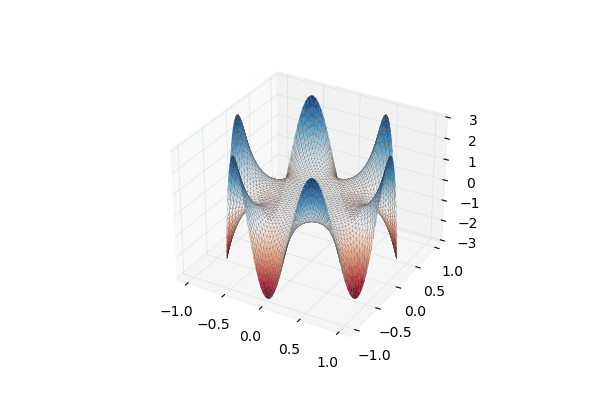

In [13]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, solution, cmap="RdBu", lw=0.1,
                edgecolor="#3c3c3c");

### Comparison with the analytical solution

In [14]:
ev_t = np.arctan2(ev_y, ev_x)
ev_r = np.sqrt(ev_x**2 + ev_y**2)
sol_fun = lambda r, t: 3*r**6*np.cos(6*t)

In [15]:
sol_analytic = sol_fun(ev_r, ev_t)

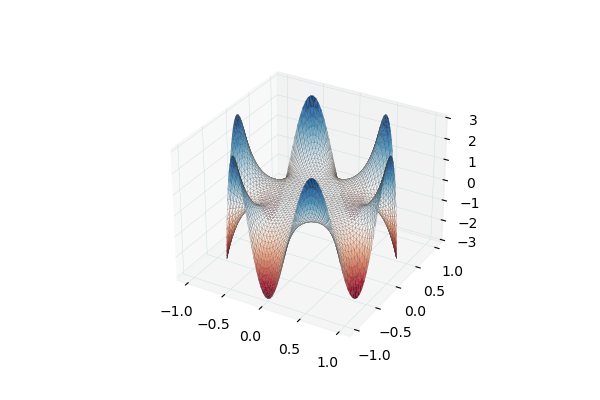

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, sol_analytic, cmap="RdBu", lw=0.1,
                edgecolor="#3c3c3c");

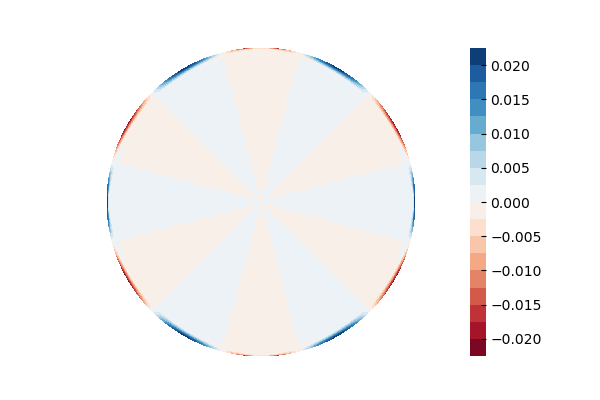

In [17]:
fig = plt.figure()
plt.tricontourf(ev_x, ev_y, sol_analytic - solution,
                18, cmap="RdBu", zorder=4)
plt.colorbar()
plt.axis("image")
plt.axis("off");

In [18]:
rel_error = 100*np.linalg.norm(sol_analytic - solution)/np.linalg.norm(sol_analytic)
print(f"The relative error is {rel_error:.2f}%")

The relative error is 0.38%
